In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax
from tqdm import tqdm
import time

#### Load the data

We have 4 datasets in total:

1. CMU Movie Metadata
2. CMU Character Metadata
3. Bechdel Intersection Movie Metadata
4. Bechdel Intersection Characters Metadata

The last two are derived by taking the intersection of CMU Movie & Character Metadata datasets and Bechdel dataset, as explained in README and with the code *bechdel_intersection.ipynb*.

In [27]:
movie_metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t')

movie_metadata.columns = ['1. Wikipedia movie ID',
                          '2. Freebase movie ID',
                          '3. Movie name',
                          '4. Movie release date',
                          '5. Movie box office revenue',
                          '6. Movie runtime',
                          '7. Movie languages (Freebase ID:name tuples)',
                          '8. Movie countries (Freebase ID:name tuples)',
                          '9. Movie genres (Freebase ID:name tuples)']

character_metadata = pd.read_csv('MovieSummaries/character.metadata.tsv',sep='\t')

character_metadata.columns = ['1. Wikipedia movie ID',
                              '2. Freebase movie ID',
                              '3. Movie release date',
                              '4. Character name',
                              '5. Actor date of birth',
                              '6. Actor gender',
                              '7. Actor height (in meters)',
                              '8. Actor ethnicity (Freebase ID)',
                              '9. Actor name',
                              '10. Actor age at movie release',
                              '11. Freebase character/actor map ID',
                              '12. Freebase character ID',
                              '13. Freebase actor ID']

movie_metadata_bechdel = pd.read_csv("CMU_bechdel_added.csv")
movie_metadata_bechdel = movie_metadata_bechdel.drop("Unnamed: 0", axis=1)
movie_metadata_bechdel.to_csv("bechdel.csv")


character_metadata_bechdel = character_metadata.copy(deep = True)
character_metadata_bechdel = character_metadata_bechdel[character_metadata_bechdel['2. Freebase movie ID'].isin(movie_metadata_bechdel["2. Freebase movie ID"].to_numpy())]

print(character_metadata_bechdel.shape)
print(character_metadata.shape)

display(movie_metadata)
display(movie_metadata_bechdel)
display(character_metadata)
display(character_metadata_bechdel)

print(movie_metadata.shape)
print(movie_metadata_bechdel.shape)
print(movie_metadata.columns)
print(movie_metadata_bechdel.columns)

(72458, 13)
(450668, 13)


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples)
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
...,...,...,...,...,...,...,...,...,...
81735,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81736,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81737,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81738,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score
0,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",3
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3
3,26878691,/m/0f400r,Mysterious Island,1982,NaN,100.0,"{""/m/0653m"": ""Standard Mandarin""}","{""/m/03h64"": ""Hong Kong""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/08322"":...",0
4,11633165,/m/02rm6l8,Innocence,1997,NaN,110.0,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",3
...,...,...,...,...,...,...,...,...,...,...
6516,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3
6517,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3
6518,21772949,/m/05mspcd,Casbah,1948-04,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/04t36"": ""Mus...",1
6519,20244619,/m/04_0j2b,Mirage,1972,NaN,82.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/016wzw"": ""Peru""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",3


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie release date,4. Character name,5. Actor date of birth,6. Actor gender,7. Actor height (in meters),8. Actor ethnicity (Freebase ID),9. Actor name,10. Actor age at movie release,11. Freebase character/actor map ID,12. Freebase character ID,13. Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
1,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
2,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
3,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
4,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450663,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450664,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450665,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450666,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie release date,4. Character name,5. Actor date of birth,6. Actor gender,7. Actor height (in meters),8. Actor ethnicity (Freebase ID),9. Actor name,10. Actor age at movie release,11. Freebase character/actor map ID,12. Freebase character ID,13. Freebase actor ID
38,2238856,/m/06yc6v,2005-01,Michael,NaN,M,NaN,NaN,Hector Elias,NaN,/m/0bf1hh6,/m/0g98dth,/m/05pxr49
39,2238856,/m/06yc6v,2005-01,Richard Swersey,1959-09-11,M,1.78,NaN,John Hawkes,NaN,/m/0k0jnm,/m/0g98dqk,/m/0785v8
40,2238856,/m/06yc6v,2005-01,Christine Jesperson,1974-02-15,F,NaN,NaN,Miranda July,NaN,/m/0k0jng,/m/0g98dqs,/m/06s5pl
41,2238856,/m/06yc6v,2005-01,Peter Swersey,NaN,M,NaN,NaN,Miles Thompson,NaN,/m/0k0jns,/m/0g98dq9,/m/0k0jml
42,2238856,/m/06yc6v,2005-01,Robby Swersey,1998-04-14,M,NaN,NaN,Brandon Ratcliff,NaN,/m/09hyqd5,/m/0g98dtr,/m/0287qtg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450598,2828945,/m/085bgh,1903-05,Fish,NaN,NaN,NaN,NaN,Norman Whitten,NaN,/m/0ltrzzd,/m/0ltrzzh,/m/0lcrrbv
450599,2828945,/m/085bgh,1903-05,Mad Hatter,NaN,NaN,NaN,NaN,Norman Whitten,NaN,/m/0ltrzvk,/m/0ltrzvn,/m/0lcrrbv
450607,20244619,/m/04_0j2b,1972,NaN,1944-08-18,F,NaN,NaN,Helena Rojo,27.0,/m/0cg4zb1,NaN,/m/0grdnq
450608,20244619,/m/04_0j2b,1972,NaN,NaN,NaN,NaN,NaN,Hernán Romero,NaN,/m/0gc63cq,NaN,/m/0gc63cv


(81740, 9)
(6521, 10)
Index(['1. Wikipedia movie ID', '2. Freebase movie ID', '3. Movie name',
       '4. Movie release date', '5. Movie box office revenue',
       '6. Movie runtime', '7. Movie languages (Freebase ID:name tuples)',
       '8. Movie countries (Freebase ID:name tuples)',
       '9. Movie genres (Freebase ID:name tuples)'],
      dtype='object')
Index(['1. Wikipedia movie ID', '2. Freebase movie ID', '3. Movie name',
       '4. Movie release date', '5. Movie box office revenue',
       '6. Movie runtime', '7. Movie languages (Freebase ID:name tuples)',
       '8. Movie countries (Freebase ID:name tuples)',
       '9. Movie genres (Freebase ID:name tuples)', 'bechdel_score'],
      dtype='object')


## Data Analysis
Now, to get an idea about the evolution of our datasets with respect to the years, we can create a histogram, representing the number of movies released every year. This can be done for both vanilla CMU movie dataset and the Bechdel Intersection dataset.

The earliest film is from the year 1010, which doesn't make sense therefore we discard it


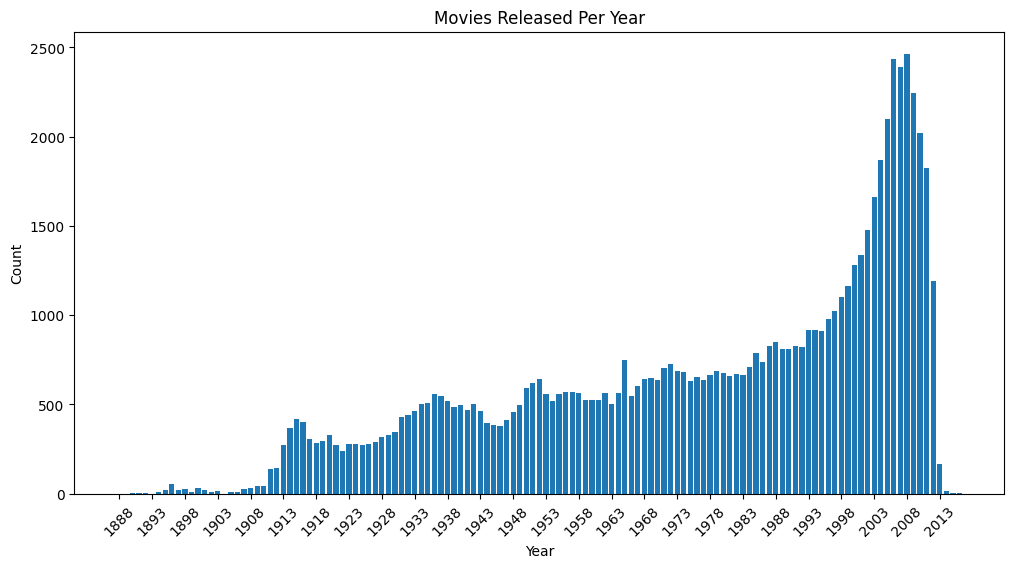

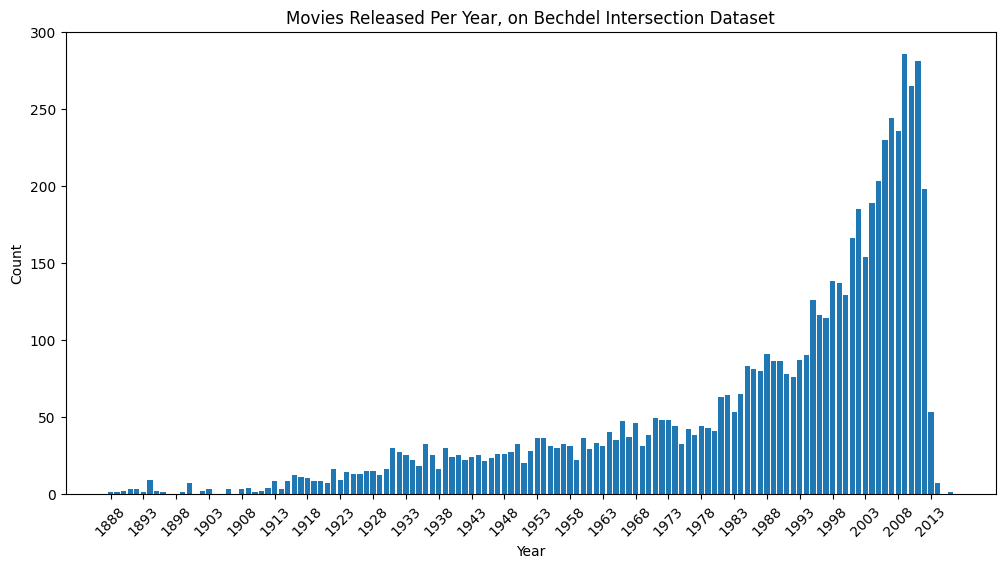

In [28]:
# We have a outlier at year 1010

# Create a copy
movie_metadata_ex = movie_metadata.copy(deep=True)
movie_metadata_bechdel_ex = movie_metadata_bechdel.copy(deep=True)

# Take off the nan values and just see the first 4 numbers (years)
year_release = (movie_metadata_ex['4. Movie release date'].dropna()).astype(str).str[:4]
year_release_bechdel = (movie_metadata_bechdel_ex['4. Movie release date'].dropna()).astype(str).str[:4]

# Count the numbers that are equal
year_release = year_release.value_counts()
year_release_bechdel = year_release_bechdel.value_counts()

# Sort the Years
year_release = year_release.sort_index()
print(str("The earliest film is from the year ")+str(np.min(year_release.index))+str(", which doesn't make sense therefore we discard it"))

#We drop year 1010
year_release=year_release[1:]

#The indices of the panda series are strings, therefore we put them into a list and convert them to int in order to be able to
#change the frequency of xticks
year_indices = year_release.index.values.tolist()
year_indices = [int(s) for s in year_indices]

year_indices_bechdel = year_release_bechdel.index.values.tolist()
year_indices_bechdel = [int(s) for s in year_indices_bechdel]

# Create a histogram
plt.figure(figsize=(12, 6))
plt.bar(year_indices, year_release.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Movies Released Per Year')

#The x-axis values overlap, we therefore seperate it by using a custom range
plt.xticks(np.arange(min(year_indices), max(year_indices), 5), rotation=45)
plt.show() 

plt.figure(figsize=(12, 6))
plt.bar(year_indices_bechdel, year_release_bechdel.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Movies Released Per Year, on Bechdel Intersection Dataset')

#The x-axis values overlap, we therefore seperate it by using a custom range
plt.xticks(np.arange(min(year_indices_bechdel), max(year_indices_bechdel), 5), rotation=45)
plt.show() 


Next, in order to understand our dataset, we may inspected how many percentage of our features are missing individually, for both CMU and Bechdel Intersection dataset.

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


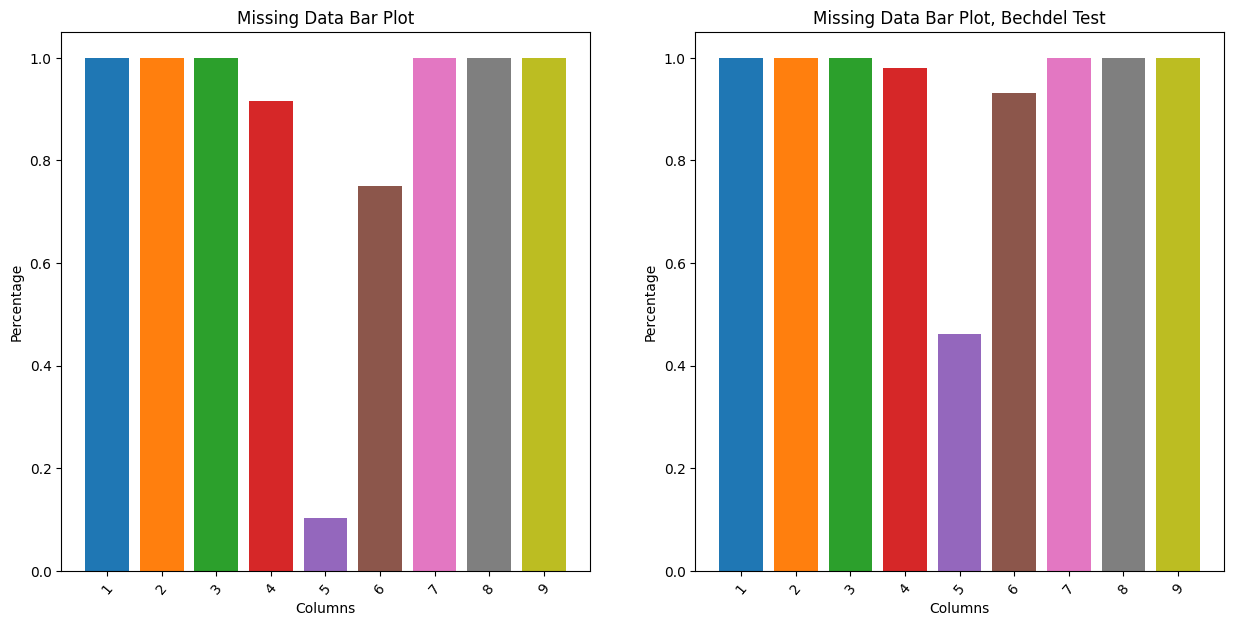

In [29]:
# Indicator variable showing that something is NA
df_analysis=movie_metadata.copy(deep=True)
df_analysis["4. Movie release date"]=df_analysis["4. Movie release date"].dropna().astype(str).str[:4]

df_analysis_bechdel=movie_metadata_bechdel.copy(deep=True)
df_analysis_bechdel["4. Movie release date"]=df_analysis_bechdel["4. Movie release date"].dropna().astype(str).str[:4]

columns_list=df_analysis.columns
fig,ax= plt.subplots(1,2, figsize=(15,7))


for column_name, index in zip(columns_list, range(0, len(columns_list))):
    print(column_name)

    df_analysis["missing_data"] = df_analysis[column_name].notna()
    mean_missing=df_analysis["missing_data"].mean()

    df_analysis_bechdel["missing_data"] = df_analysis_bechdel[column_name].notna()
    mean_missing_bechdel=df_analysis_bechdel["missing_data"].mean()


    ax[0].bar(column_name,mean_missing)
    ax[1].bar(column_name,mean_missing_bechdel)

ax[0].set_ylabel("Percentage")
ax[0].set_xlabel("Columns")
ax[0].set_title(f"Missing Data Bar Plot");
ticks = ax[0].get_xticks();  # Get the current tick positions
ax[0].set_xticks(ticks);
ticks = [s+1 for s in ticks]
ax[0].set_xticklabels(ticks, rotation = 50);

ax[1].set_ylabel("Percentage")
ax[1].set_xlabel("Columns")
ax[1].set_title(f"Missing Data Bar Plot, Bechdel Test");
ticks = ax[1].get_xticks();  # Get the current tick positions
ax[1].set_xticks(ticks);
ticks = [s+1 for s in ticks]
ax[1].set_xticklabels(ticks, rotation = 50);

We observe that the majority of the box office data is missing. In order to visualize it better, we are going to look at the year by year evolution of the missing data. This may help by indicating which year interval should we focus on, if we were to complete our dataset for the missing values.

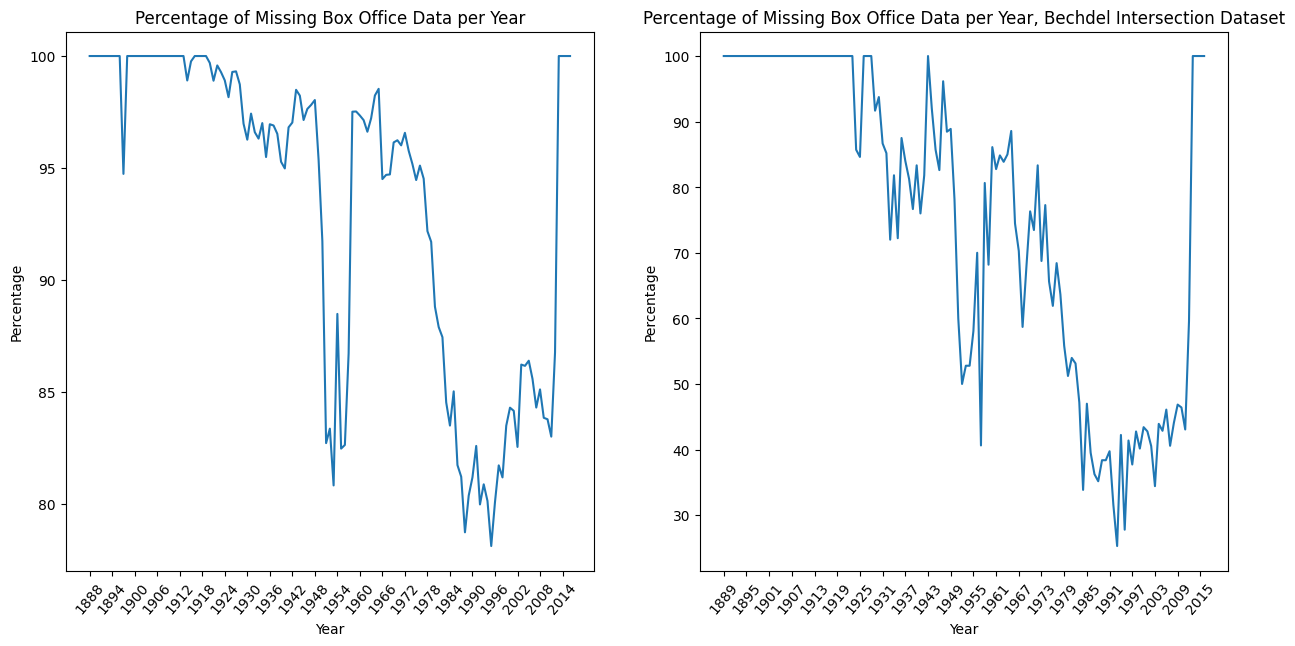

In [30]:
df_analysis["boffice_is_na"] = df_analysis["5. Movie box office revenue"].isna()
missing_boffice_data = df_analysis.groupby("4. Movie release date")["boffice_is_na"].mean()
index_values=missing_boffice_data.index.values.tolist()
index_values = [int(s) for s in index_values[1:]]

df_analysis_bechdel["boffice_is_na"] = df_analysis_bechdel["5. Movie box office revenue"].isna()
missing_boffice_data_bechdel = df_analysis_bechdel.groupby("4. Movie release date")["boffice_is_na"].mean()
index_values_bechdel = missing_boffice_data_bechdel.index.values.tolist()
index_values_bechdel = [int(s) for s in index_values_bechdel[1:]]

#Visualize
fig,ax= plt.subplots(1,2, figsize=(15,7))

ax[0].plot(index_values, 100*missing_boffice_data.to_numpy()[1:])
ax[0].set_ylabel("Percentage")
ax[0].set_xlabel("Year")
ax[0].set_xticks(np.arange(min(index_values), max(index_values)+1, 6))
ax[0].set_xticklabels(ax[0].get_xticks(), rotation = 50)
ax[0].set_title("Percentage of Missing Box Office Data per Year");

ax[1].plot(index_values_bechdel, 100* missing_boffice_data_bechdel.to_numpy()[1:])
ax[1].set_ylabel("Percentage")
ax[1].set_xlabel("Year")
ax[1].set_xticks(np.arange(min(index_values_bechdel), max(index_values_bechdel)+1, 6))
ax[1].set_xticklabels(ax[1].get_xticks(), rotation = 50)
ax[1].set_title("Percentage of Missing Box Office Data per Year, Bechdel Intersection Dataset");
plt.show()

Again, same analysis may be done for the character metadata. This dataset is not complete as well and includes some missing values. 

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


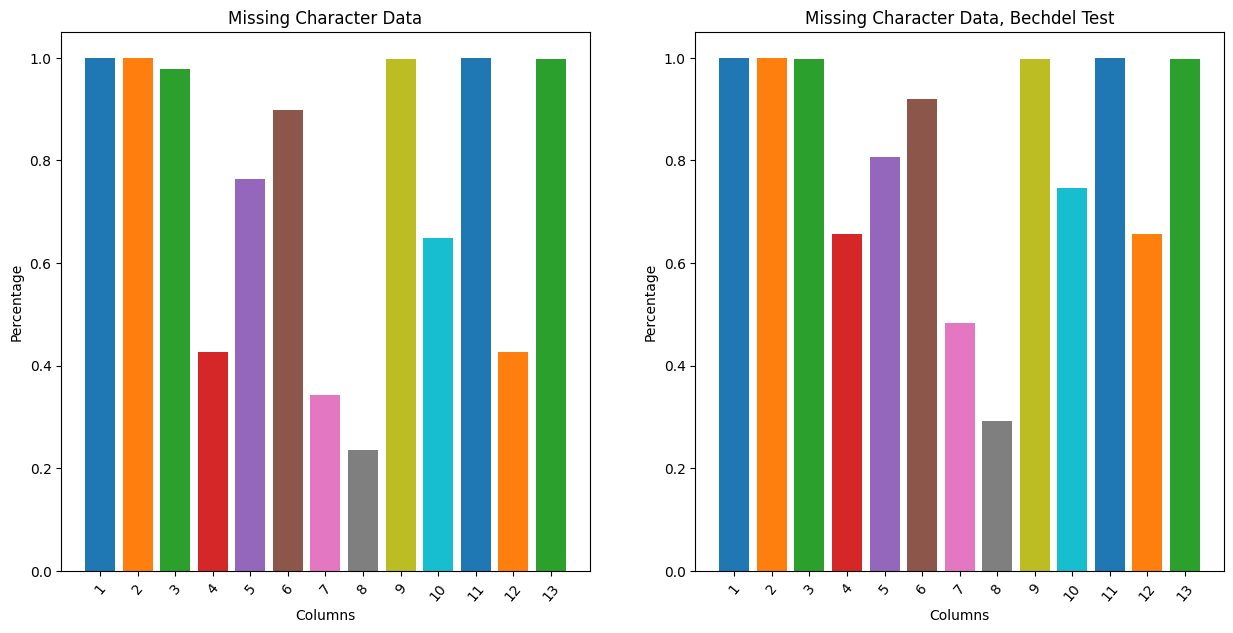

In [31]:
# Indicator variable showing that something is NA
character_missing_analysis=character_metadata.copy(deep=True)
character_missing_analysis["3. Movie release date"]=character_missing_analysis["3. Movie release date"].dropna().astype(str).str[:4]

character_missing_analysis_bechdel = character_metadata_bechdel.copy(deep=True)
character_missing_analysis_bechdel["3. Movie release date"]=character_missing_analysis_bechdel["3. Movie release date"].dropna().astype(str).str[:4]


columns_list=character_missing_analysis.columns
fig,ax= plt.subplots(1,2, figsize=(15,7))


for column_name, index in zip(columns_list, range(0, len(columns_list))):
    print(column_name)

    character_missing_analysis["missing_data"] = character_missing_analysis[column_name].notna()
    mean_missing = character_missing_analysis["missing_data"].mean()
    
    character_missing_analysis_bechdel["missing_data"] = character_missing_analysis_bechdel[column_name].notna()
    mean_missing_bechdel = character_missing_analysis_bechdel["missing_data"].mean()

    #Visualize
    ax[0].bar(column_name,mean_missing)
    ax[1].bar(column_name,mean_missing_bechdel)


ax[0].set_ylabel("Percentage")
ax[0].set_xlabel("Columns")
ax[0].set_title(f"Missing Character Data");
ticks = ax[0].get_xticks()  # Get the current tick positions
ax[0].set_xticks(ticks)
ticks = [s+1 for s in ticks]
ax[0].set_xticklabels(ticks, rotation = 50);
    
ax[1].set_ylabel("Percentage")
ax[1].set_xlabel("Columns")
ax[1].set_title(f"Missing Character Data, Bechdel Test");
ticks = ax[1].get_xticks()  # Get the current tick positions
ax[1].set_xticks(ticks)
ticks = [s+1 for s in ticks]
ax[1].set_xticklabels(ticks, rotation = 50);

We may observe that there is a significant missing data for the features:

1. Character Name
2. Actor Height
3. Actor Ethnicity
4. Freebase Character ID

But there is no need to handle these missing values, since they will not be a part of our analysis for the moment.

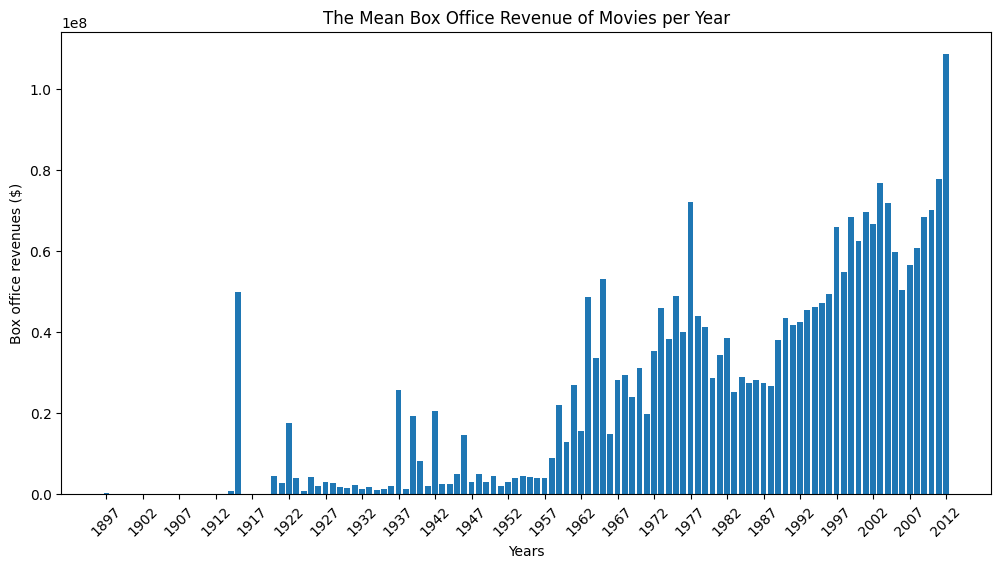

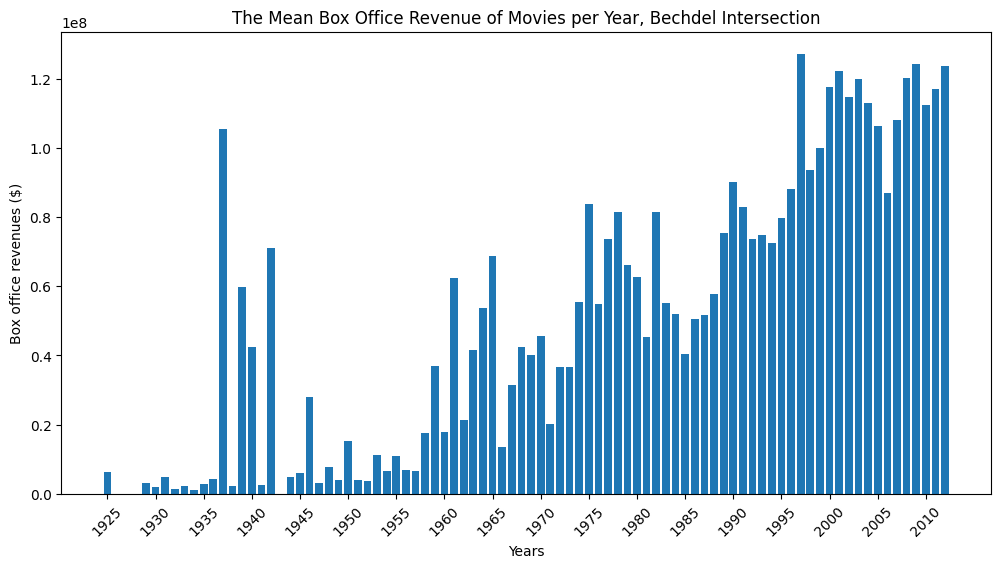

In [32]:
movie_metadata_box = movie_metadata.copy(deep=True)
movie_metadata_box_bechdel = movie_metadata_bechdel.copy(deep=True)
#We first drop the rows where either box office revenue or year data is missing
movie_metadata_dropped = movie_metadata.dropna(subset=['5. Movie box office revenue', '4. Movie release date'])
movie_metadata_dropped_bechdel = movie_metadata_bechdel.dropna(subset=['5. Movie box office revenue', '4. Movie release date'])

#We then take the first 4 digits of the year which correspond to the year
movie_metadata_dropped.loc[:, '4. Movie release date']=movie_metadata_dropped['4. Movie release date'].str[:4]
movie_metadata_dropped_bechdel.loc[:, '4. Movie release date']=movie_metadata_dropped_bechdel['4. Movie release date'].str[:4]

#We group the data by the release dates and take the mean box office revenue ($) of each year except the first outlier (year 1010)
grouped=movie_metadata_dropped.groupby(by='4. Movie release date')['5. Movie box office revenue'].mean()[1:]
index_values=grouped.index.values.tolist()
index_values = [int(s) for s in index_values]

grouped_bechdel=movie_metadata_dropped_bechdel.groupby(by='4. Movie release date')['5. Movie box office revenue'].mean()[1:]
index_values_bechdel=grouped_bechdel.index.values.tolist()
index_values_bechdel = [int(s) for s in index_values_bechdel]

plt.figure(figsize=(12, 6))
plt.bar(index_values, grouped)
plt.xticks(np.arange(min(index_values), max(index_values)+1, 5),rotation=45)
plt.xlabel("Years")
plt.ylabel("Box office revenues ($)")
plt.title("The Mean Box Office Revenue of Movies per Year")
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(index_values_bechdel, grouped_bechdel)
plt.xticks(np.arange(min(index_values_bechdel), max(index_values_bechdel)+1, 5),rotation=45)
plt.xlabel("Years")
plt.ylabel("Box office revenues ($)")
plt.title("The Mean Box Office Revenue of Movies per Year, Bechdel Intersection")
plt.show()

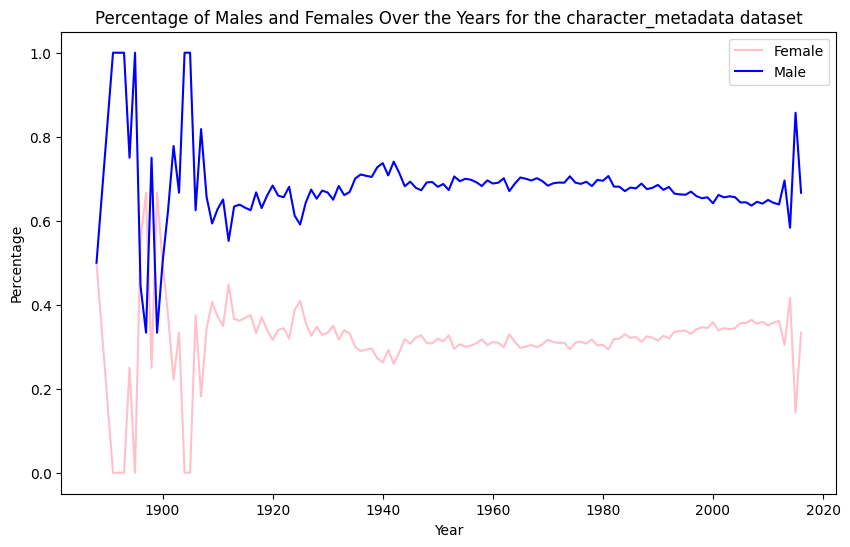

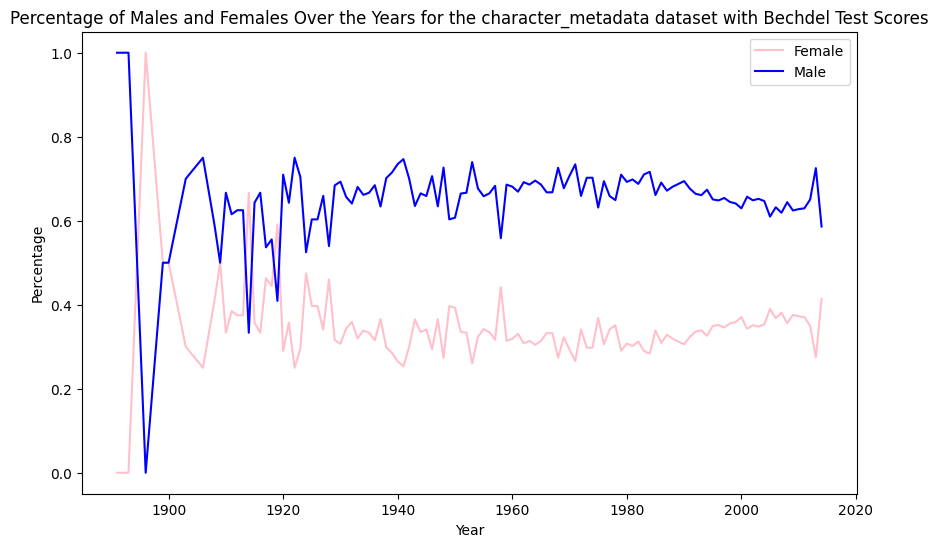

In [33]:
#create a list of the copies of raw character metadata and the one intersected with the bechdel
character_metadatas = [character_metadata.copy(), character_metadata_bechdel.copy()]

for index, character_metadata_ex in enumerate(character_metadatas):
    
    character_metadata_ex['3. Movie release date'] = character_metadata_ex['3. Movie release date'].str[:4]
    character_metadata_ex.dropna(subset=["3. Movie release date", "6. Actor gender"], inplace=True)
    character_metadata_ex['3. Movie release date'] = character_metadata_ex['3. Movie release date'].astype(int) #convert the years to integer

    # Group the data, calculate the percentage of female/male cast members
    movies = character_metadata_ex.groupby(['3. Movie release date', '6. Actor gender']).size().unstack(fill_value=0)
    movies = movies[1:]  #Remove the outlier year 1010
    movies['Total'] = movies.sum(axis=1)
    movies['Percentage of F'] = movies['F'] / movies['Total']
    movies['Percentage of M'] = movies['M'] / movies['Total']

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=movies, x=movies.index, y='Percentage of F', color='pink', label='Female')
    sns.lineplot(data=movies, x=movies.index, y='Percentage of M', color='blue', label='Male')

    if index == 0:
        plt.title("Percentage of Males and Females Over the Years for the character_metadata dataset")
    else:
        plt.title("Percentage of Males and Females Over the Years for the character_metadata dataset with Bechdel Test Scores")
    plt.xlabel('Year')
    plt.ylabel('Percentage')

plt.show()

## Bechdel Test Intersection Analysis
It might be insightfull to solely inspect and analyze this newly added column to our initial CMU dataset, which is the Bechdel score for each of the movies, with the values [0, 1, 2, 3] depending on the how many tests the movie has passed.

First, we may inspect the distribution of the labels, and then, we may check the correlation between this test and the box office scores for the present data.

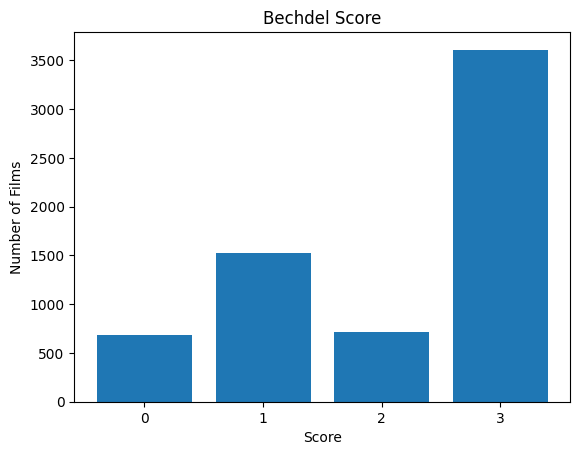

In [34]:
df_bechdel = movie_metadata_bechdel.copy(deep=True)

bechdel_score = df_bechdel['bechdel_score']

labels, counts = np.unique(bechdel_score, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Bechdel Score')
plt.xlabel('Score')
plt.ylabel('Number of Films')

plt.show()

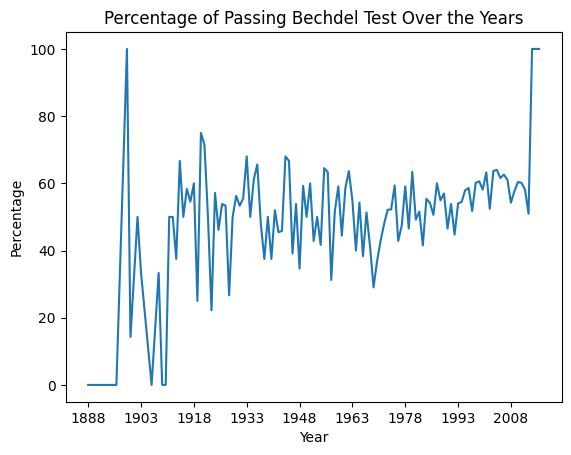

In [35]:
# Create a copy
df_bechdel_ex = movie_metadata_bechdel.copy(deep=True)

# We then take the first 4 digits of the year which correspond to the year
df_bechdel_ex.loc[:, '4. Movie release date']=df_bechdel_ex['4. Movie release date'].str[:4]

df_bechdel_ex['4. Movie release date']=df_bechdel_ex['4. Movie release date'].dropna().astype(int)

# Group by year
year_data_CMU = df_bechdel_ex.groupby(['4. Movie release date','bechdel_score']).size().unstack(fill_value = 0)

#display(year_data_CMU)

year_data_CMU['Total'] = year_data_CMU[0]+year_data_CMU[1]+year_data_CMU[2]+year_data_CMU[3]
year_data_CMU['Percentage of Passing'] = (year_data_CMU[3]/year_data_CMU['Total'])*100

#display(year_data_CMU['Total'].sum())
#display(year_data_CMU['Percentage of Passing'])

plt.plot(year_data_CMU['Percentage of Passing'])
plt.title('Percentage of Passing Bechdel Test Over the Years')
plt.xticks(np.arange(min(df_bechdel_ex['4. Movie release date']), max(df_bechdel_ex['4. Movie release date']+1),15))
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.show()

Number of Fail: 1376 
Number of Pass: 1637


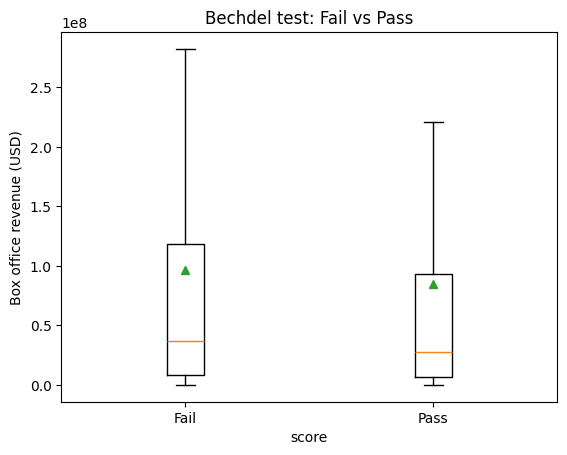

In [36]:
df_bechdel = movie_metadata_bechdel.copy(deep=True)

# filter
df_bechdel_no = df_bechdel[df_bechdel['bechdel_score'] != 3]
df_bechdel_0 = df_bechdel[df_bechdel['bechdel_score'] == 0]
df_bechdel_1 = df_bechdel[df_bechdel['bechdel_score'] == 1]
df_bechdel_2 = df_bechdel[df_bechdel['bechdel_score'] == 2]
df_bechdel_3 = df_bechdel[df_bechdel['bechdel_score'] == 3]

# remove from dataframes to raw data
bechdel_no = df_bechdel_no['5. Movie box office revenue'].dropna()
bechdel_0 = df_bechdel_0['5. Movie box office revenue'].dropna()
bechdel_1 = df_bechdel_1['5. Movie box office revenue'].dropna()
bechdel_2 = df_bechdel_2['5. Movie box office revenue'].dropna()
bechdel_3 = df_bechdel_3['5. Movie box office revenue'].dropna()

# boxplot 1: compare complete pass (3) vs fail(!3)

# Create a figure and axes
fig, ax = plt.subplots()

# Create two boxplots in one figure
ax.boxplot([bechdel_no, bechdel_3], labels=['Fail', 'Pass'], showfliers=False, showmeans=True)

# Set labels and title
ax.set_xlabel('score')
ax.set_ylabel('Box office revenue (USD)')
ax.set_title('Bechdel test: Fail vs Pass')

print('Number of Fail: {} \nNumber of Pass: {}'.format(len(bechdel_no), len(bechdel_3)))
# Show the plot
plt.show()

Looks like not completely passing the test have higher box offices, lets focus on the differentiation between scores (Simpsons Paradox?).
Plotting the box plots for each possible number of tests passed (0, 1, 2, 3):

Number of 0: 236 
Number of 1: 795 
Number of 2: 345 
Number of 3: 1637


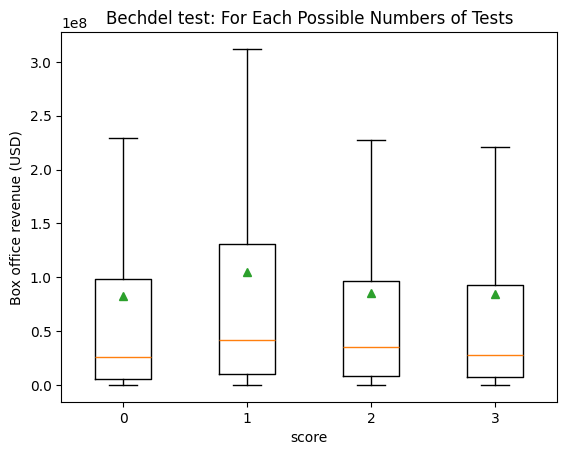

In [37]:
# Create a figure and axes
fig, ax = plt.subplots()

# Create two boxplots in one figure
ax.boxplot([bechdel_0, bechdel_1, bechdel_2, bechdel_3], labels=['0', '1', '2', '3'], showfliers=False, showmeans=True)

# Set labels and title
ax.set_xlabel('score')
ax.set_ylabel('Box office revenue (USD)')
ax.set_title('Bechdel test: For Each Possible Numbers of Tests')


print('Number of 0: {} \nNumber of 1: {} \nNumber of 2: {} \nNumber of 3: {}'.format(len(bechdel_0), len(bechdel_1), len(bechdel_2), len(bechdel_3)))
# Show the plot
plt.show()

In [38]:
plot_summaries=pd.read_csv('../ada-2023-project-pandamonium/MovieSummaries/plot_summaries.txt', sep='\t', header=None, names=['id', 'plot_summary'])
plot_summaries.head()

,id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [39]:
# Define the model
""" MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)


scores_final=[]
for i, row in tqdm(plot_summaries.iterrows(), total=plot_summaries.shape[0]):
    encoded_text = tokenizer(row[1], return_tensors='pt', truncation=True, max_length=512).to(device)

    output = model(**encoded_text)

    scores = output[0][0].detach().cpu().numpy()

    scores = softmax(scores)

    scores_dict = {
        'index': row[0],
        'negative': scores[0],
        'neutral': scores[1],
        'positive': scores[2]
    }
    scores_final.append(scores_dict)
    
print(scores_final[100]) """

' MODEL = "cardiffnlp/twitter-roberta-base-sentiment"\n\ntokenizer = AutoTokenizer.from_pretrained(MODEL)\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)\n\n\nscores_final=[]\nfor i, row in tqdm(plot_summaries.iterrows(), total=plot_summaries.shape[0]):\n    encoded_text = tokenizer(row[1], return_tensors=\'pt\', truncation=True, max_length=512).to(device)\n\n    output = model(**encoded_text)\n\n    scores = output[0][0].detach().cpu().numpy()\n\n    scores = softmax(scores)\n\n    scores_dict = {\n        \'index\': row[0],\n        \'negative\': scores[0],\n        \'neutral\': scores[1],\n        \'positive\': scores[2]\n    }\n    scores_final.append(scores_dict)\n    \nprint(scores_final[100]) '

In [40]:
#sentiments=scores_final.copy()
#sentiments=pd.DataFrame(sentiments)
#sentiments.to_csv("sentiment_analysis.csv", index=False)
sentiments=pd.read_csv("sentiment_analysis.csv")
sentiments.head()

,index,negative,neutral,positive
0,23890098,0.083211,0.481692,0.435097
1,31186339,0.302852,0.623645,0.073503
2,20663735,0.446035,0.518429,0.035536
3,2231378,0.426033,0.493325,0.080642
4,595909,0.534127,0.436248,0.029625


In [41]:
sentiments = sentiments.rename(columns={'index': '1. Wikipedia movie ID'})

movie_metadata_sentiments=movie_metadata_bechdel.copy(deep=True)
movie_metadata_sentiments = pd.merge(movie_metadata_sentiments, sentiments, on='1. Wikipedia movie ID', how='left')
display(movie_metadata_sentiments)
movie_metadata_sentiments=movie_metadata_sentiments.dropna(subset=["negative"])
display(movie_metadata_sentiments)

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,negative,neutral,positive
0,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",3,NaN,NaN,NaN
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.048826,0.830560,0.120614
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.129004,0.691920,0.179076
3,26878691,/m/0f400r,Mysterious Island,1982,NaN,100.0,"{""/m/0653m"": ""Standard Mandarin""}","{""/m/03h64"": ""Hong Kong""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/08322"":...",0,NaN,NaN,NaN
4,11633165,/m/02rm6l8,Innocence,1997,NaN,110.0,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6516,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.131713,0.691487,0.176800
6517,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.317630,0.585357,0.097013
6518,21772949,/m/05mspcd,Casbah,1948-04,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/04t36"": ""Mus...",1,NaN,NaN,NaN
6519,20244619,/m/04_0j2b,Mirage,1972,NaN,82.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/016wzw"": ""Peru""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",3,0.111646,0.724559,0.163794


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,negative,neutral,positive
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.048826,0.830560,0.120614
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.129004,0.691920,0.179076
5,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.252773,0.634228,0.112999
6,1369204,/m/04x8zs,Juarez,1939,NaN,125.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/03bxz7"": ""B...",2,0.394391,0.572009,0.033601
7,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01yldk"": ""Softcore Porn"", ""/m/06b0n3"": ""S...",3,0.398135,0.527754,0.074110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.384289,0.565830,0.049881
6516,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.131713,0.691487,0.176800
6517,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.317630,0.585357,0.097013
6519,20244619,/m/04_0j2b,Mirage,1972,NaN,82.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/016wzw"": ""Peru""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",3,0.111646,0.724559,0.163794


<BarContainer object of 3 artists>

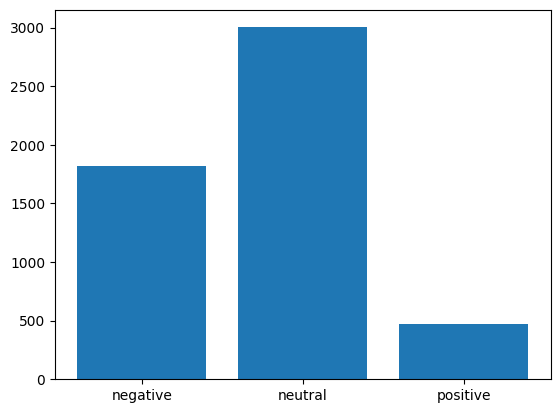

In [42]:
sentiment_counts = movie_metadata_sentiments[["negative", "neutral", "positive"]].sum()
plt.bar(["negative","neutral","positive"], sentiment_counts.values)

In [43]:
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
tokenizer = RegexpTokenizer(r'\w+')
counts=[{"1. Wikipedia movie ID":0,"she":0, "her":0, "he":0, "his":0} for i in range(plot_summaries.shape[0])]

for i, row in tqdm(plot_summaries.iterrows(), total=plot_summaries.shape[0]):
    tokens = tokenizer.tokenize(row[1])
    counts[i]["1. Wikipedia movie ID"]=row[0]
    counts[i]["she"]=tokens.count("she")
    counts[i]["her"]=tokens.count("her")
    counts[i]["he"]=tokens.count("he")
    counts[i]["his"]=tokens.count("his")
    

  0%|          | 0/42303 [00:00<?, ?it/s]C:\Users\mriza\AppData\Local\Temp\ipykernel_51640\296271352.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tokens = tokenizer.tokenize(row[1])
C:\Users\mriza\AppData\Local\Temp\ipykernel_51640\296271352.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  counts[i]["1. Wikipedia movie ID"]=row[0]
100%|██████████| 42303/42303 [00:04<00:00, 8557.64it/s]


In [44]:
print(counts[100])
genders=pd.DataFrame(counts)
display(genders.head())

{'1. Wikipedia movie ID': 4803289, 'she': 6, 'her': 1, 'he': 10, 'his': 18}


,1. Wikipedia movie ID,she,her,he,his
0,23890098,0,0,0,0
1,31186339,10,12,2,2
2,20663735,1,3,2,16
3,2231378,0,6,8,14
4,595909,6,6,2,6


,1. Wikipedia movie ID,she,her,he,his,gender_density
1,31186339,10,12,2,2,0.846154
2,20663735,1,3,2,16,0.181818
3,2231378,0,6,8,14,0.214286
4,595909,6,6,2,6,0.600000
5,5272176,1,2,4,5,0.250000


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,negative,neutral,positive,she,her,he,his,gender_density
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.048826,0.830560,0.120614,0.0,0.0,0.0,1.0,0.000000
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.129004,0.691920,0.179076,7.0,9.0,12.0,20.0,0.333333
2,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.252773,0.634228,0.112999,2.0,4.0,8.0,11.0,0.240000
3,1369204,/m/04x8zs,Juarez,1939,NaN,125.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/03bxz7"": ""B...",2,0.394391,0.572009,0.033601,1.0,0.0,3.0,8.0,0.083333
4,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01yldk"": ""Softcore Porn"", ""/m/06b0n3"": ""S...",3,0.398135,0.527754,0.074110,0.0,5.0,0.0,0.0,1.000000


Text(0.5, 1.0, 'Pronoun frequencies')

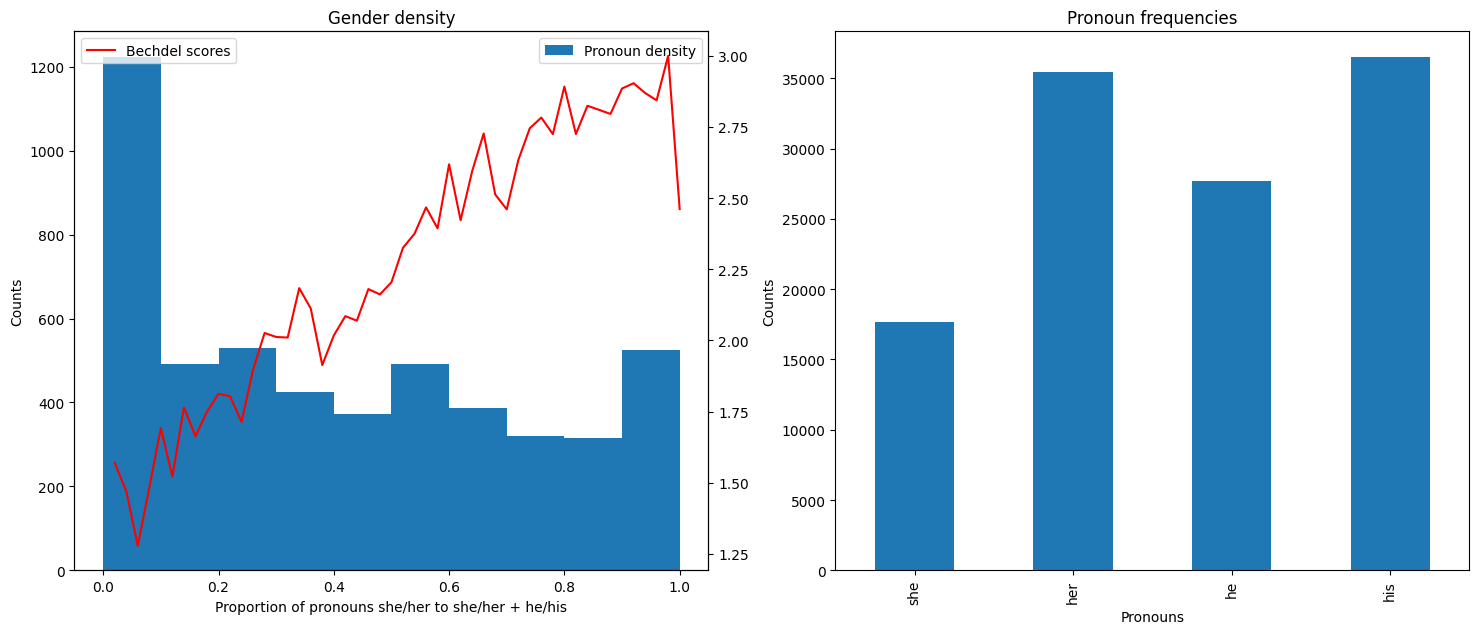

In [45]:
genders["gender_density"]=(genders['she'] + genders['her']) / (genders['she'] + genders['her'] + genders['he'] + genders['his'])

genders=genders.dropna()
display(genders.head())
movie_metadata_genders=pd.merge(movie_metadata_sentiments, genders, on='1. Wikipedia movie ID', how='left')
display(movie_metadata_genders.head())

sorted_genders = movie_metadata_genders.sort_values('gender_density')
bins =  np.arange(0, 1.0, 1/50)
ind = np.digitize(sorted_genders['gender_density'], bins)
    
bechdel_means=sorted_genders.groupby(ind)["bechdel_score"].mean()

fig, ax= plt.subplots(1,2, figsize=(18,7))
ax[0].hist(movie_metadata_genders["gender_density"], label='Pronoun density')
ax[0].set_xlabel("Proportion of pronouns she/her to she/her + he/his")
ax[0].set_ylabel("Counts")
ax[0].set_title("Gender density")
ax2 = ax[0].twinx()
ax2.plot(bechdel_means.index/50,bechdel_means, color='red', label='Bechdel scores')
ax[0].legend()
ax2.legend()


genders_sum=movie_metadata_genders[["she","her", "he", "his"]].sum()
genders_sum.plot(kind='bar',ax=ax[1])
ax[1].set_xlabel("Pronouns")
ax[1].set_ylabel("Counts")
ax[1].set_title("Pronoun frequencies")

In [46]:
from scipy.stats import spearmanr
movie_metadata_genders=movie_metadata_genders.dropna(subset=["5. Movie box office revenue", "gender_density"])
spearman_corr, spearman_p_value = spearmanr(movie_metadata_genders['5. Movie box office revenue'], movie_metadata_genders['gender_density'])

print(f"Spearman correlation: {spearman_corr}")
print(f"P-value: {spearman_p_value}")

Spearman correlation: -0.13832025327130812
P-value: 8.94022134243412e-14


In [47]:
print(movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel[movie_metadata_bechdel['2. Freebase movie ID'].isin(character_metadata_bechdel["2. Freebase movie ID"].to_numpy())]
print(movie_metadata_bechdel.shape)

(6521, 10)
(6202, 10)


In [48]:
plot_summaries=pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None, names=['id', 'plot_summary'])
plot_summaries_bechdel = plot_summaries[plot_summaries['id'].isin(character_metadata_bechdel['1. Wikipedia movie ID'].to_numpy())]

plot_summaries.head()
print(plot_summaries.shape)
print(plot_summaries_bechdel.shape)

print("Movie Metadata Before sync:",movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel[movie_metadata_bechdel['1. Wikipedia movie ID'].isin(plot_summaries_bechdel["id"].to_numpy())]
print("Movie Metadata Before sync:",movie_metadata_bechdel.shape)

(42303, 2)
(5194, 2)
Movie Metadata Before sync: (6202, 10)
Movie Metadata Before sync: (5194, 10)


In [52]:
movie_idx = 255


def calculate_actor_mention_score(movie_idx):
    movie_summary = plot_summaries_bechdel.iloc[movie_idx]["plot_summary"]
    
    #Tokenize the movie summary
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(movie_summary)
    tokens = [x.lower() for x in tokens]
    tokens_freq = pd.Series(tokens).value_counts(sort=True)
    
    #align movie dataset & character dataset
    movie_id = plot_summaries_bechdel.iloc[movie_idx]["id"]
    character_list = character_metadata_bechdel[character_metadata_bechdel['1. Wikipedia movie ID'] == movie_id][['4. Character name','6. Actor gender']]
    
    character_list_processed = character_list.copy()
    character_list_processed = character_list_processed.dropna()

    #Lowercase character names
    character_list_processed["4. Character name"] = character_list_processed["4. Character name"].str.lower()

    #Split full name and only get the first name
    character_list_processed["4. Character name"] = character_list_processed["4. Character name"].str.split(' ').str[0]

    character_list_processed = character_list_processed.drop(character_list_processed[character_list_processed["4. Character name"] == "the"].index)

    character_gender_stacked = character_list_processed.drop_duplicates(subset='4. Character name', keep=False)
    character_gender_stacked_idx = character_gender_stacked.set_index("4. Character name")

    #Take the intersection between the token's frequency and movie cast
    tokens_intersection = tokens_freq[character_gender_stacked_idx.index.intersection(tokens_freq.index)]
    character_gender_stacked = character_gender_stacked.drop_duplicates()
    character_mention_freq = character_gender_stacked[character_gender_stacked["4. Character name"].isin(tokens_intersection.index)]#.drop_duplicates()

    #Add the number of character mentions in summary to the character meta-dataset
    character_mention_freq = character_mention_freq.copy()
    character_mention_freq.loc[:, "no_mention"] = tokens_intersection.values
#pd.DataFrame({'4. Character name':character_mention_freq[0], 'no_mention':character_mention_freq.values})
    character_mention_freq.columns = ["character_name", "gender", "no_mention"]
    character_list_final = character_mention_freq
    #print(character_list_final)
    
    #Group by gender and calculate total number of mentions by gender
    character_list_freq_added = character_list_final.groupby(['gender']).sum()
    if len(character_list_freq_added['no_mention'].index) != 0:
        if character_list_freq_added['no_mention'].shape[0] == 2:
            female_mention, male_mention = character_list_freq_added['no_mention'].iloc[0], character_list_freq_added['no_mention'].iloc[1] #groupby is alphabethic, index 0 = F
            mention_ratio = female_mention/(female_mention + male_mention)
        elif character_list_freq_added['no_mention'].index[0] == "M":
            mention_ratio = 0.
        elif character_list_freq_added['no_mention'].index[0] == "F":
            mention_ratio = 1.
        else:
            mention_ratio = np.nan
    else:
        mention_ratio = np.nan

    actor_mention_score = round(mention_ratio, 4)
    
    return actor_mention_score, movie_id


In [53]:

beginning = time.time()

for a in tqdm(range(movie_metadata_bechdel.shape[0]-1)):#movie_metadata_bechdel.shape[0]-1):
    actor_mention_score, movie_id = calculate_actor_mention_score(a+1)
    #print(actor_mention_score, movie_id)
    
    movie_metadata_bechdel.loc[movie_metadata_bechdel['1. Wikipedia movie ID'] == movie_id, "actor_mention_score"] = actor_mention_score
    #print(movie_metadata_bechdel.loc[movie_metadata_bechdel['1. Wikipedia movie ID'] == movie_id, "actor_mention_score"])
#print(movie_metadata_bechdel)
#print(time.time() - beginning)

100%|██████████| 5193/5193 [00:26<00:00, 198.99it/s]


In [54]:
display(movie_metadata_bechdel)
#movie_metadata_bechdel.to_csv("movie_metadata_bechdel.csv", index=False)
movie_metadata_bechdel=pd.read_csv("movie_metadata_bechdel.csv")

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.2500
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.5345
5,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.2830
6,1369204,/m/04x8zs,Juarez,1939,NaN,125.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/03bxz7"": ""B...",2,NaN
7,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01yldk"": ""Softcore Porn"", ""/m/06b0n3"": ""S...",3,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6514,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.7500
6516,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.1667
6517,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.5200
6519,20244619,/m/04_0j2b,Mirage,1972,NaN,82.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/016wzw"": ""Peru""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",3,NaN


(array([944., 394., 447., 342., 295., 375., 232., 170., 168., 546.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

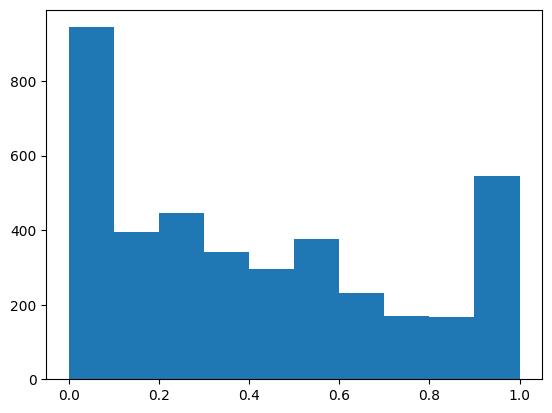

In [55]:
plt.hist(movie_metadata_bechdel["actor_mention_score"])

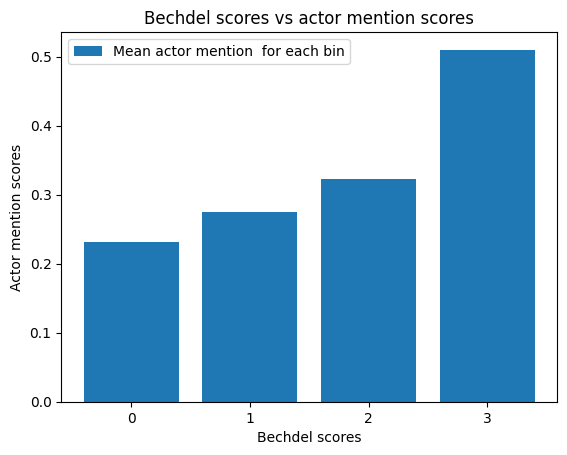

In [56]:
movie_metadata_bechdel=movie_metadata_bechdel.dropna(subset=["6. Movie runtime", "actor_mention_score"])
mention_group=movie_metadata_bechdel.groupby("bechdel_score")["actor_mention_score"].mean()

x=mention_group.index
plt.bar(x, mention_group.values, tick_label=x, label="Mean actor mention  for each bin")
plt.xlabel("Bechdel scores")
plt.ylabel("Actor mention scores")
plt.title("Bechdel scores vs actor mention scores")
plt.legend()
plt.show()

In [57]:
from scipy.stats import pearsonr

spearman_corr, spearman_p_value = pearsonr(movie_metadata_bechdel['6. Movie runtime'], movie_metadata_bechdel['actor_mention_score'])

print(f"Spearman correlation: {spearman_corr}")
print(f"P-value: {spearman_p_value}")

Spearman correlation: -0.056562819186301204
P-value: 0.0004544183954404244
